# Phosphoproteomic aberrations associated with molecular signatures

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings
from sklearn.linear_model import LogisticRegressionCV   
from msresist.figures.figureM1 import filter_NaNpeptides
from msresist.logistic_regression import plotClusterCoefficients, plotPredictionProbabilities, plotConfusionMatrix, plotROC
from sklearn.cross_decomposition import PLSRegression

sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## Import and Preprocess Data

In [2]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

# filter peptides with excessive missingness
X_f = filter_NaNpeptides(X, cut=0.1)
X_f.index = np.arange(X_f.shape[0])
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

X_f.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071547,-0.600298,0.172339,-1.761406,0.421872,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.25423,-0.378522,0.987749,-0.189486
1,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83783,-0.993838,0.317079,...,0.031572,-0.554645,-0.033640,-1.268642,0.266790,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsGPsPP,NP_060895.1,PI4K2A,S44-p;S47-p,0.477744,-1.231926,-1.600599,-1.349858,0.388473,-0.649326,0.394909,-1.041745,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAPsPGSAR,NP_036253.2,CDC42EP4,S292-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load Clustering Model from Figure 2

In [3]:
ncl = 15
with open('CPTACmodel_PAM250_W0075_15CL', 'rb') as f:
    MSC = pickle.load(f)[0]

## Regression against mutation status of driver genes and clusters

#### Import mutation status of TP53, KRAS, EGFR, and ALK fusion 

In [4]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
mOI = mutations[["Sample.ID", "TP53.mutation.status", "KRAS.mutation.status", "EGFR.mutation.status", "ALK.fusion"]]
mOI = mOI[~mOI["Sample.ID"].str.contains("IR")]

#### Import clusters

In [5]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]
assert list(mOI["Sample.ID"]) == list(centers["Patient_ID"]), "Patients don't match"

x, y = centers.set_index("Patient_ID"), mOI.set_index("Sample.ID")

### Logistic Regression

EGFR mutation status

In [21]:
c = centers.iloc[:, :-1]
y_egfr = y["EGFR.mutation.status"]

lr = LogisticRegressionCV(cv=50, solver="saga", penalty="l1", class_weight={0:0.56, 1:0.80}).fit(c, y_egfr)
y_pred = lr.predict(c)

lr_score = lr.score(c, y_egfr)
print("LR prediction score: ", lr_score)

LR prediction score:  0.8744186046511628


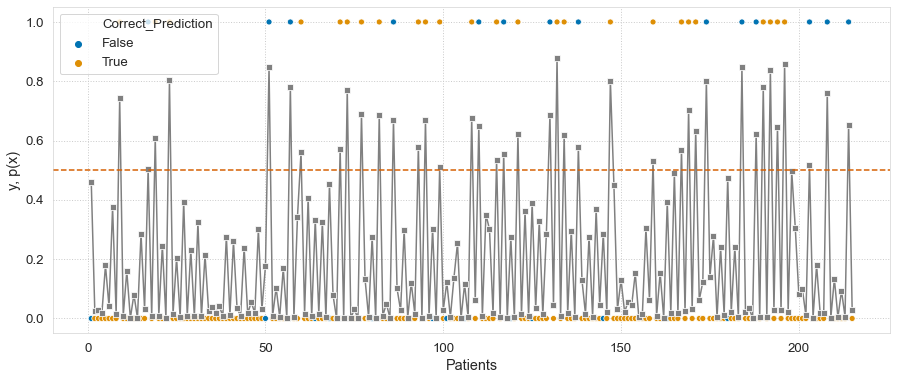

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plotPredictionProbabilities(ax, lr, y_pred, c, y_egfr)

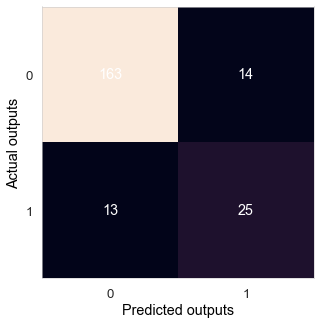

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr, c, y_egfr)

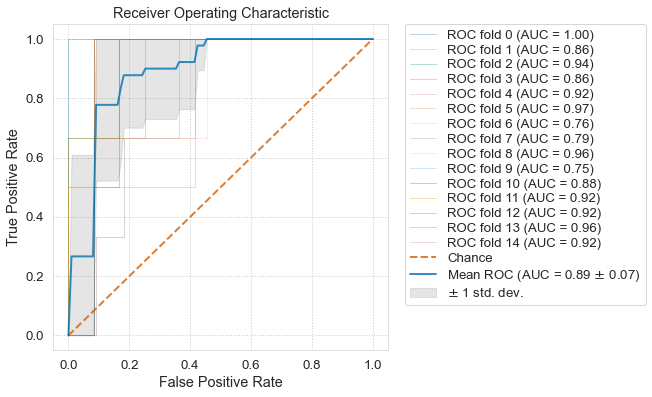

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
plotROC(ax, lr, c, y_egfr, cv_folds=ncl)

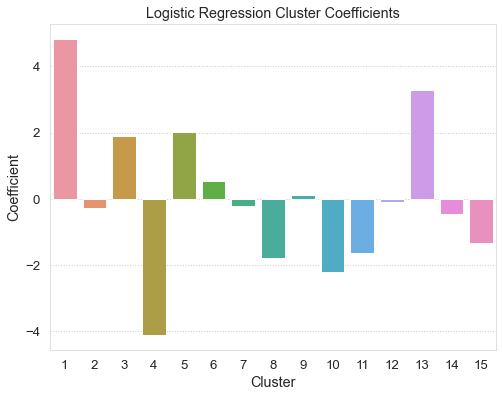

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr)

TP53 mutation status

In [1]:
from sklearn.linear_model import LogisticRegressionCV
c = centers.iloc[:, :-1]
y_tp53 = y["TP53.mutation.status"]

lr = LogisticRegressionCV(cv=ncl, solver="saga", penalty="elastic", class_weight="balanced").fit(c, y_tp53)
y_pred = lr.predict(c)

lr_score = lr.score(c, y_tp53)
print("LR prediction score: ", lr_score)

NameError: name 'centers' is not defined

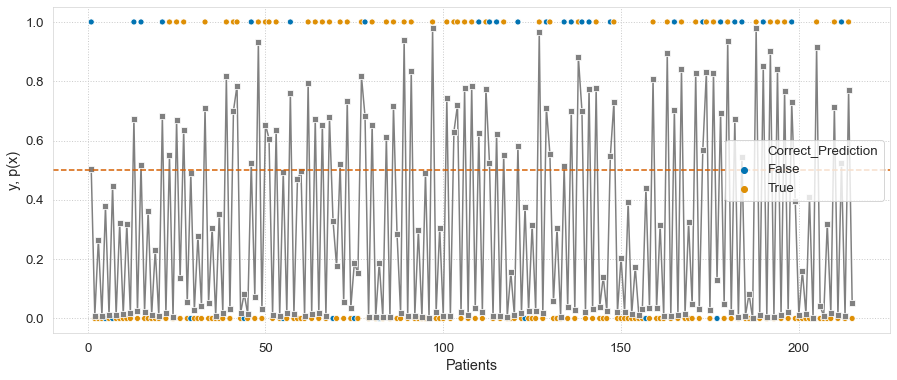

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plotPredictionProbabilities(ax, lr, y_pred, c, y_tp53)

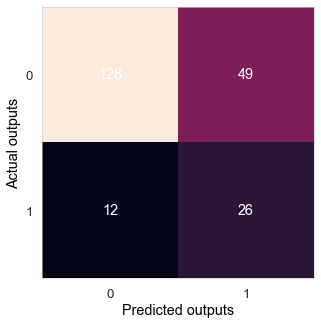

In [156]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr, c, y_egfr)

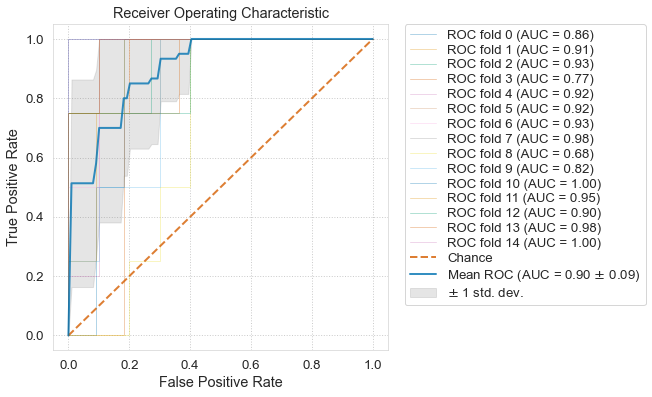

In [157]:
fig, ax = plt.subplots(figsize=(6, 6))
plotROC(ax, lr, c, y_tp53, cv_folds=ncl)

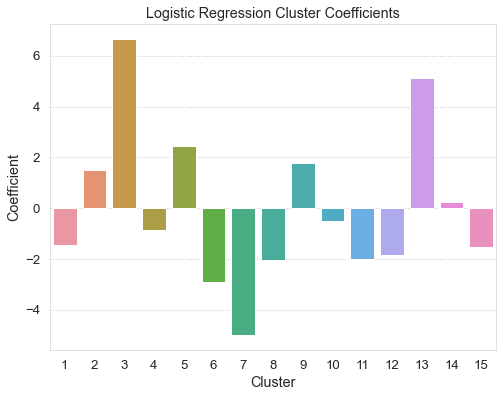

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr)